In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

In [2]:
## load the data

full_df = pd.read_pickle("2010_data_interpolated.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,4.351527e-06,4.876077e-09,3.969704e-06,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,2.926953e-06,25.761255,25.615093,2.107318e-06,4.285939e-06,3.294435e-06,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,1.630353e-06
1,77.826608,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,3.582948e-06,4.927685e-09,2.205362e-06,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,2.456049e-06,27.814162,27.673807,2.637130e-06,5.442802e-06,4.337687e-06,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,1.191268e-06
2,75.841973,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,4.185584e-06,4.877634e-09,3.576529e-06,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,2.568678e-06,26.033231,25.892798,2.087401e-06,4.249902e-06,3.340465e-06,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,1.224486e-06
3,73.705432,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,4.347974e-06,4.880969e-09,3.728783e-06,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,3.335762e-06,25.483006,25.334140,2.013939e-06,4.098991e-06,3.148080e-06,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,2.044144e-06
4,75.753407,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,4.065276e-06,4.892594e-09,2.665721e-06,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,3.732430e-06,24.141938,23.988644,1.665682e-06,3.365222e-06,2.598917e-06,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,2.475384e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.699994,278.306938,0.004731,0.018000,0.004273,2.963378,0.521521,101612.298364,0.043443,7.211313e-09,1.085390e-08,0.004944,0.797428,288.800929,0.016638,0.023680,78671.597311,268.952507,0.081071,0.000645,0.000003,1.057181e-06,4.940441e-09,8.240240e-08,0.007670,0.000003,0.000002,4.936414e-07,0.006922,0.000005,5.097700e-07,1.752316e-06,7.935474,7.862793,5.575145e-07,1.294505e-06,3.974618e-06,9.234859e-08,0.000002,4.103250e-07,0.000008,2.020761e-07,0.000012,8.884089e-07,0.000003,1.334658e-06
3123,83.771012,267.448043,273.873965,0.004740,0.018000,0.001595,2.573796,2.378314,101622.979506,0.044644,6.583338e-09,9.402720e-09,0.005779,0.806610,309.101498,0.099861,0.021002,74693.719536,268.553249,0.077760,0.000607,0.000002,8.023640e-07,4.846817e-09,7.718545e-08,0.007256,0.000002,0.000001,2.632511e-07,0.007037,0.000004,4.883845e-07,5.185750e-07,6.433924,6.340060,2.703968e-07,5.

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.55


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()

In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')

RMSE scores for each fold: [1.40214168 1.46307741 1.62540766 1.57690696]
Mean RMSE score: 1.5168834298280096
Standard deviation of RMSE scores: 0.08865817855901635


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'max_features': [10,20,30], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
CPU times: total: 15min 4s
Wall time: 1min 35s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [10, 20, 30],
                          'min_samples_split': [5, 10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=150, max_features=10, min_samples_split=10,
                      n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.85


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.62


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.34


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.88


In [14]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.63


In [15]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.87
The adjusted test r_sq ::: 0.60


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

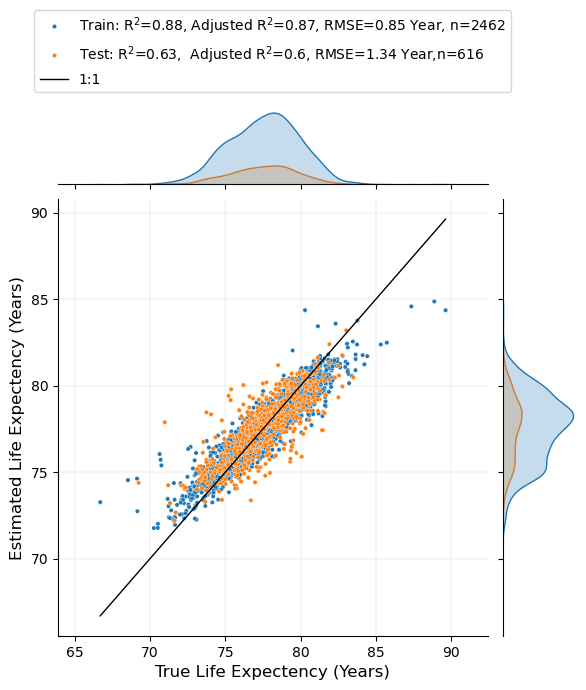

In [96]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  



g.ax_joint.legend(handles=handles,  
    labels=[ f'Train: R$^2$={corr_train}, Adjusted R$^2$={train_adjusted_r2}, RMSE={rmse_train} Year, n={len(X_train)}', 
        f'Test: R$^2$={corr_test},  Adjusted R$^2$={test_adjusted_r2}, RMSE={rmse_test} Year,n={len(X_test)}','1:1'],
                        title=None)

sns.move_legend(g.ax_joint, "upper center", bbox_to_anchor=(0.5, 1.45))

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

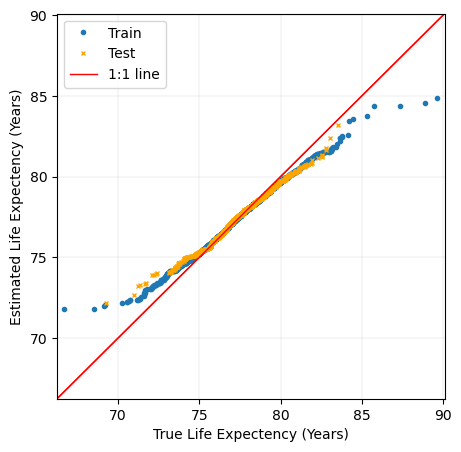

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

## Find feature importance on the train set

In [19]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
train_permutation

{'importances_mean': array([ 5.17974182e-02,  6.03317144e-02,  2.64454717e-02,  8.33082558e-03,
         8.53410670e-02,  3.50025695e-02,  3.54669608e-02,  1.19997422e-01,
         3.37381203e-02, -4.93432455e-17, -1.23358114e-17,  2.68523288e-02,
         3.38514290e-02,  3.89798575e-02,  2.70248847e-02,  7.23574263e-02,
         3.25458222e-02,  4.02742736e-02,  3.83092121e-02,  3.51737903e-02,
         2.51477886e-04,  1.02049580e-03, -7.40148683e-17,  8.48387411e-03,
         2.72018306e-02,  2.39951393e-03,  6.94230397e-03,  1.43183942e-04,
         4.95354905e-02,  3.10027336e-03,  2.15638968e-05,  3.28643414e-03,
         5.29512003e-02,  6.94691385e-02,  6.41350503e-04,  3.35507456e-03,
         5.85461802e-03, -7.40148683e-17,  2.31928189e-03,  1.26549952e-04,
         7.98953677e-03,  2.51717638e-05,  1.31093382e-02,  2.41324653e-03,
         5.13173446e-03,  2.63517752e-03]),
 'importances_std': array([2.05738973e-03, 1.50571615e-03, 1.31296220e-03, 3.98800934e-04,
        2

In [20]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [21]:
mean_val

array([ 5.17974182e-02,  6.03317144e-02,  2.64454717e-02,  8.33082558e-03,
        8.53410670e-02,  3.50025695e-02,  3.54669608e-02,  1.19997422e-01,
        3.37381203e-02, -4.93432455e-17, -1.23358114e-17,  2.68523288e-02,
        3.38514290e-02,  3.89798575e-02,  2.70248847e-02,  7.23574263e-02,
        3.25458222e-02,  4.02742736e-02,  3.83092121e-02,  3.51737903e-02,
        2.51477886e-04,  1.02049580e-03, -7.40148683e-17,  8.48387411e-03,
        2.72018306e-02,  2.39951393e-03,  6.94230397e-03,  1.43183942e-04,
        4.95354905e-02,  3.10027336e-03,  2.15638968e-05,  3.28643414e-03,
        5.29512003e-02,  6.94691385e-02,  6.41350503e-04,  3.35507456e-03,
        5.85461802e-03, -7.40148683e-17,  2.31928189e-03,  1.26549952e-04,
        7.98953677e-03,  2.51717638e-05,  1.31093382e-02,  2.41324653e-03,
        5.13173446e-03,  2.63517752e-03])

In [22]:
mean_importance

[(0.11999742177780733, 'msl'),
 (0.08534106695662697, 'duaod550'),
 (0.07235742634555847, 'suaod550'),
 (0.069469138519902, 'tcwv'),
 (0.06033171440223558, 't2m'),
 (0.052951200284548396, 'tcw'),
 (0.051797418173545516, 'd2m'),
 (0.0495354904686754, 'gtco3'),
 (0.04027427358315897, 'tsn'),
 (0.038979857479188605, 'rsn'),
 (0.03830921205200424, 'aod550'),
 (0.035466960781798194, 'lai_lv'),
 (0.03517379034991911, 'tcco'),
 (0.03500256951139999, 'lai_hv'),
 (0.03385142900908519, 'asn'),
 (0.033738120268366166, 'omaod550'),
 (0.03254582217118365, 'sp'),
 (0.027201830564072993, 'tc_ch4'),
 (0.02702488470263151, 'sd'),
 (0.026852328846258766, 'ssaod550'),
 (0.02644547174490661, 'bcaod550'),
 (0.01310933823651101, 'aermssssm'),
 (0.008483874105636323, 'tc_c5h8'),
 (0.008330825583514488, 'chnk'),
 (0.007989536769387715, 'aermssomhphob'),
 (0.0069423039661069925, 'tcno2'),
 (0.005854618022795275, 'aermssdul'),
 (0.005131734459360943, 'aermsssu'),
 (0.0033550745627713985, 'aermssdum'),
 (0.00328

In [23]:
std_importance

[(0.004278484681841596, 'msl'),
 (0.00245026013767125, 'duaod550'),
 (0.002057389731796302, 'd2m'),
 (0.0020358730777206803, 'tcwv'),
 (0.0015196767684087656, 'lai_hv'),
 (0.00150571614858253, 't2m'),
 (0.0014919999912915076, 'tsn'),
 (0.0014318984097502002, 'suaod550'),
 (0.0014132890120458319, 'tcw'),
 (0.001408849472832449, 'tcco'),
 (0.001355881750455545, 'aod550'),
 (0.0013129622043269857, 'bcaod550'),
 (0.0012936111958426247, 'gtco3'),
 (0.0011417229986880506, 'lai_lv'),
 (0.0010611238351496413, 'rsn'),
 (0.0009088120660211166, 'asn'),
 (0.0008243739354821832, 'sd'),
 (0.0008112415661393425, 'aermssomhphob'),
 (0.0007537797339791648, 'sp'),
 (0.0007262981979382792, 'omaod550'),
 (0.0006954427563388761, 'tc_ch4'),
 (0.0005775537100911731, 'ssaod550'),
 (0.0005421165717207038, 'aermssssm'),
 (0.0003988009340362741, 'chnk'),
 (0.0003669596052477502, 'tc_c5h8'),
 (0.0003627508751111288, 'aermssdul'),
 (0.000291927730118913, 'aermssomhphil'),
 (0.00028744586549903816, 'aermsssu'),
 (0

In [24]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

          Feature   Mean Weight  Standard Deviation
7             msl  1.199974e-01        4.278485e-03
4        duaod550  8.534107e-02        2.450260e-03
15       suaod550  7.235743e-02        1.431898e-03
33           tcwv  6.946914e-02        2.035873e-03
1             t2m  6.033171e-02        1.505716e-03
32            tcw  5.295120e-02        1.413289e-03
0             d2m  5.179742e-02        2.057390e-03
28          gtco3  4.953549e-02        1.293611e-03
17            tsn  4.027427e-02        1.492000e-03
13            rsn  3.897986e-02        1.061124e-03
18         aod550  3.830921e-02        1.355882e-03
6          lai_lv  3.546696e-02        1.141723e-03
19           tcco  3.517379e-02        1.408849e-03
5          lai_hv  3.500257e-02        1.519677e-03
12            asn  3.385143e-02        9.088121e-04
8        omaod550  3.373812e-02        7.262982e-04
16             sp  3.254582e-02        7.537797e-04
24         tc_ch4  2.720183e-02        6.954428e-04
14          

<Axes: xlabel='Mean Weight', ylabel='Feature'>

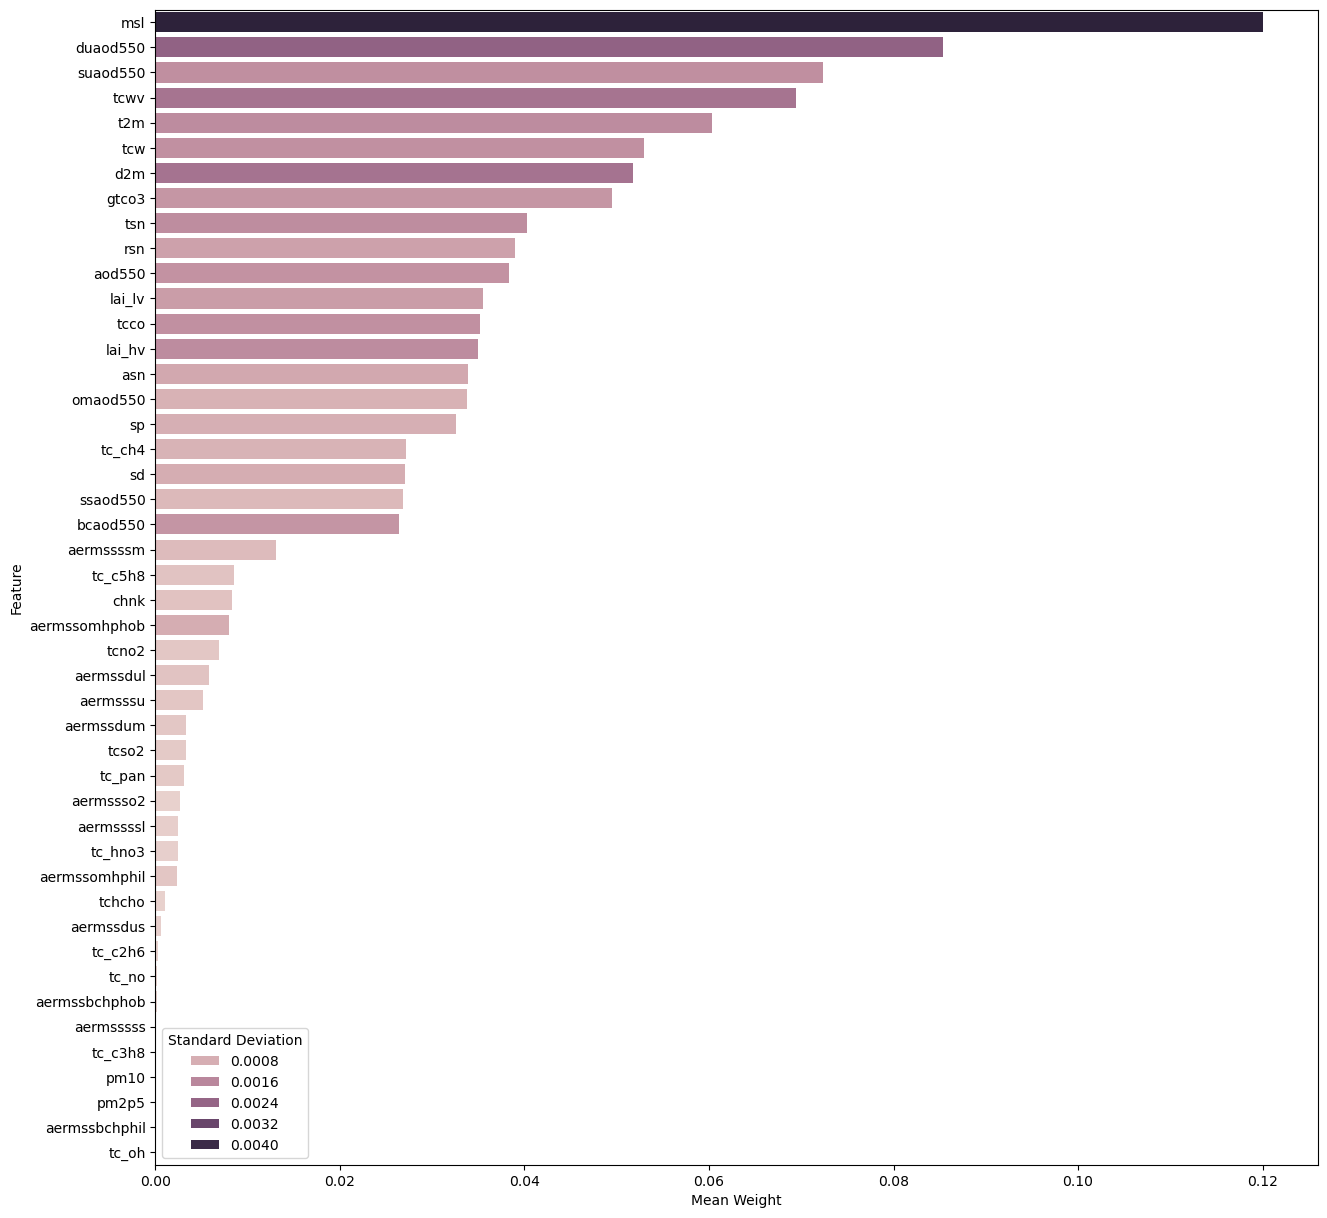

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find permutation importance in test set

In [26]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5

<Axes: xlabel='Mean Weight', ylabel='Feature'>

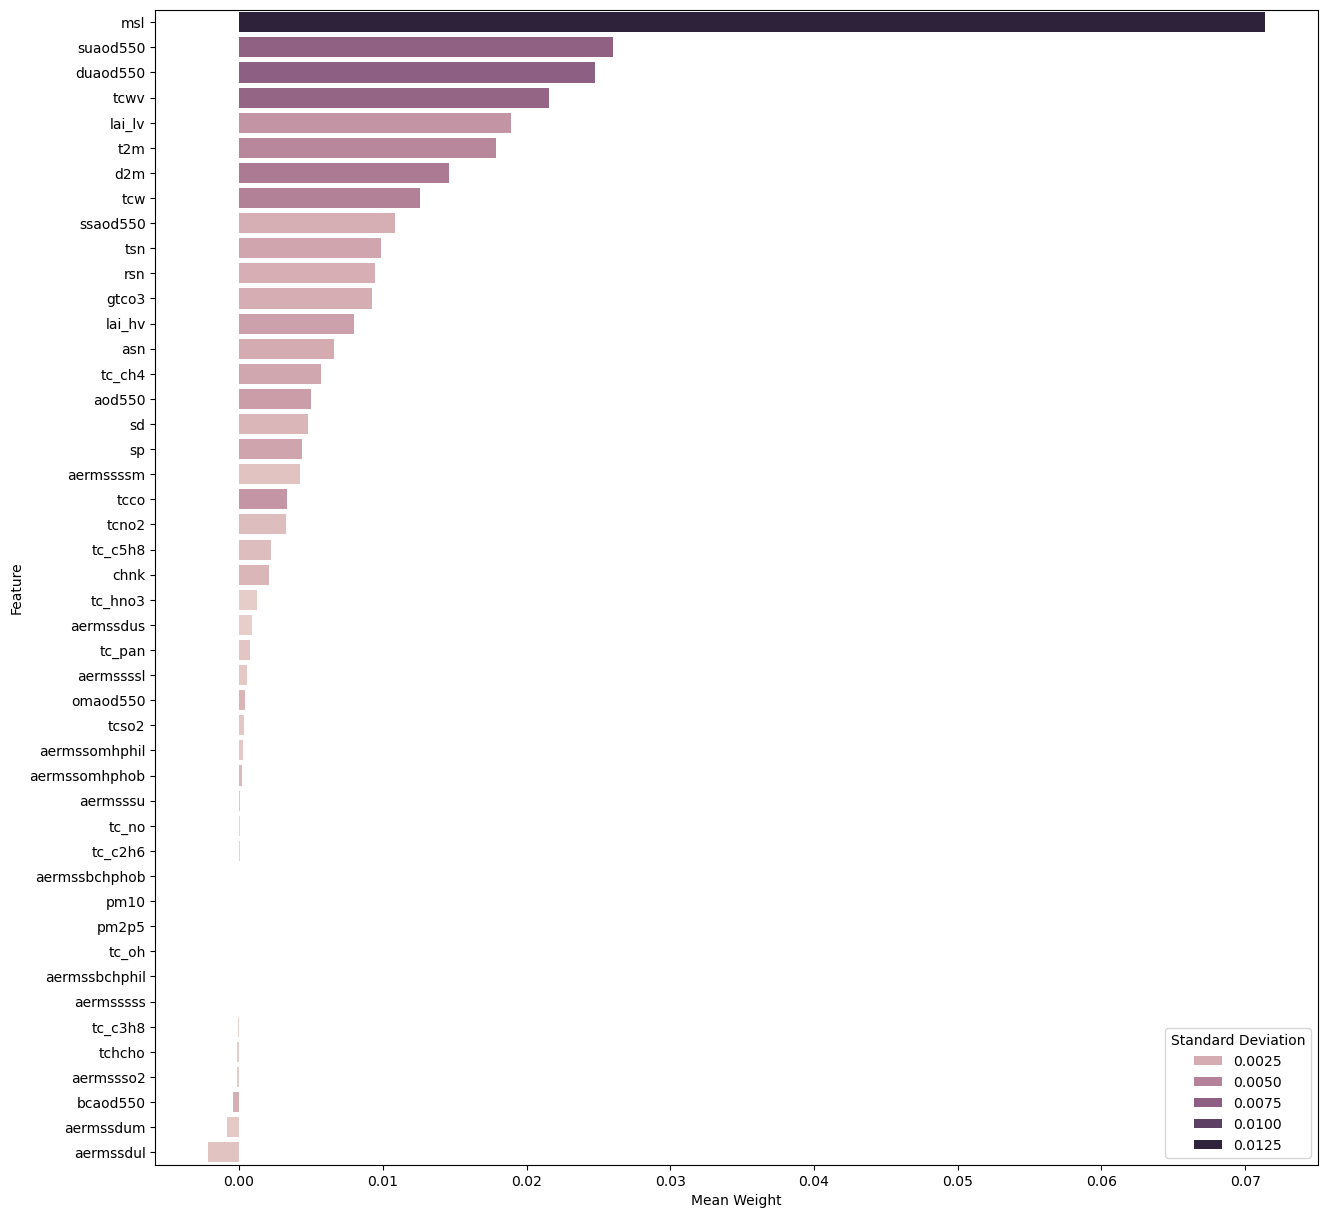

In [27]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

In [28]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

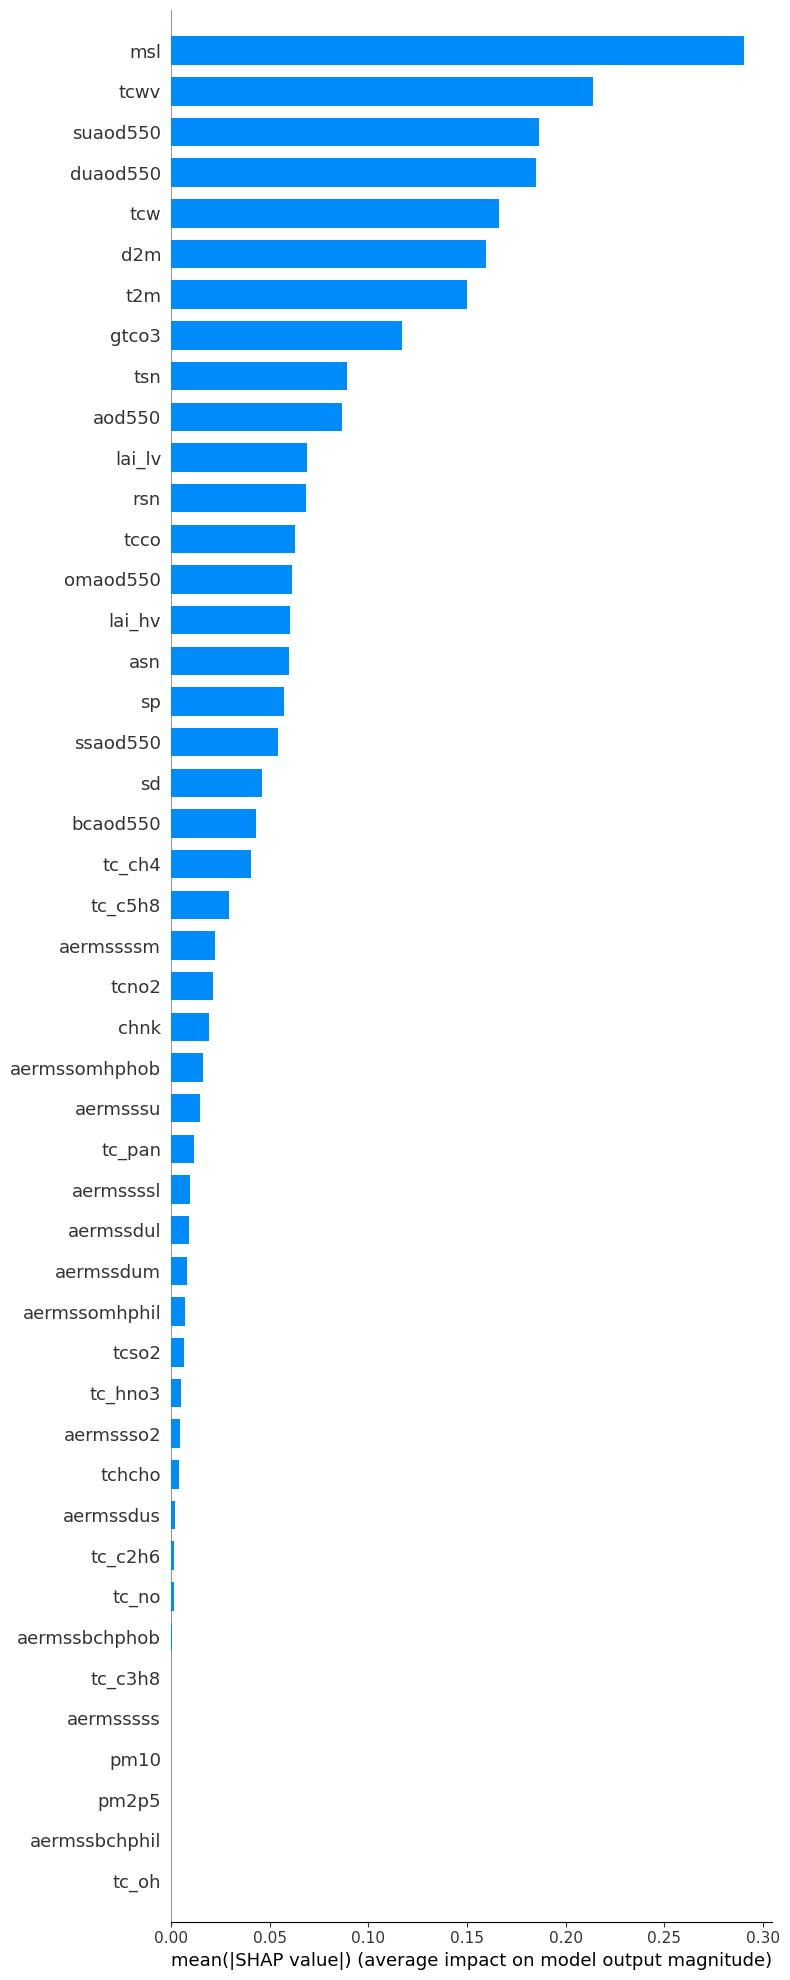

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

In [30]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

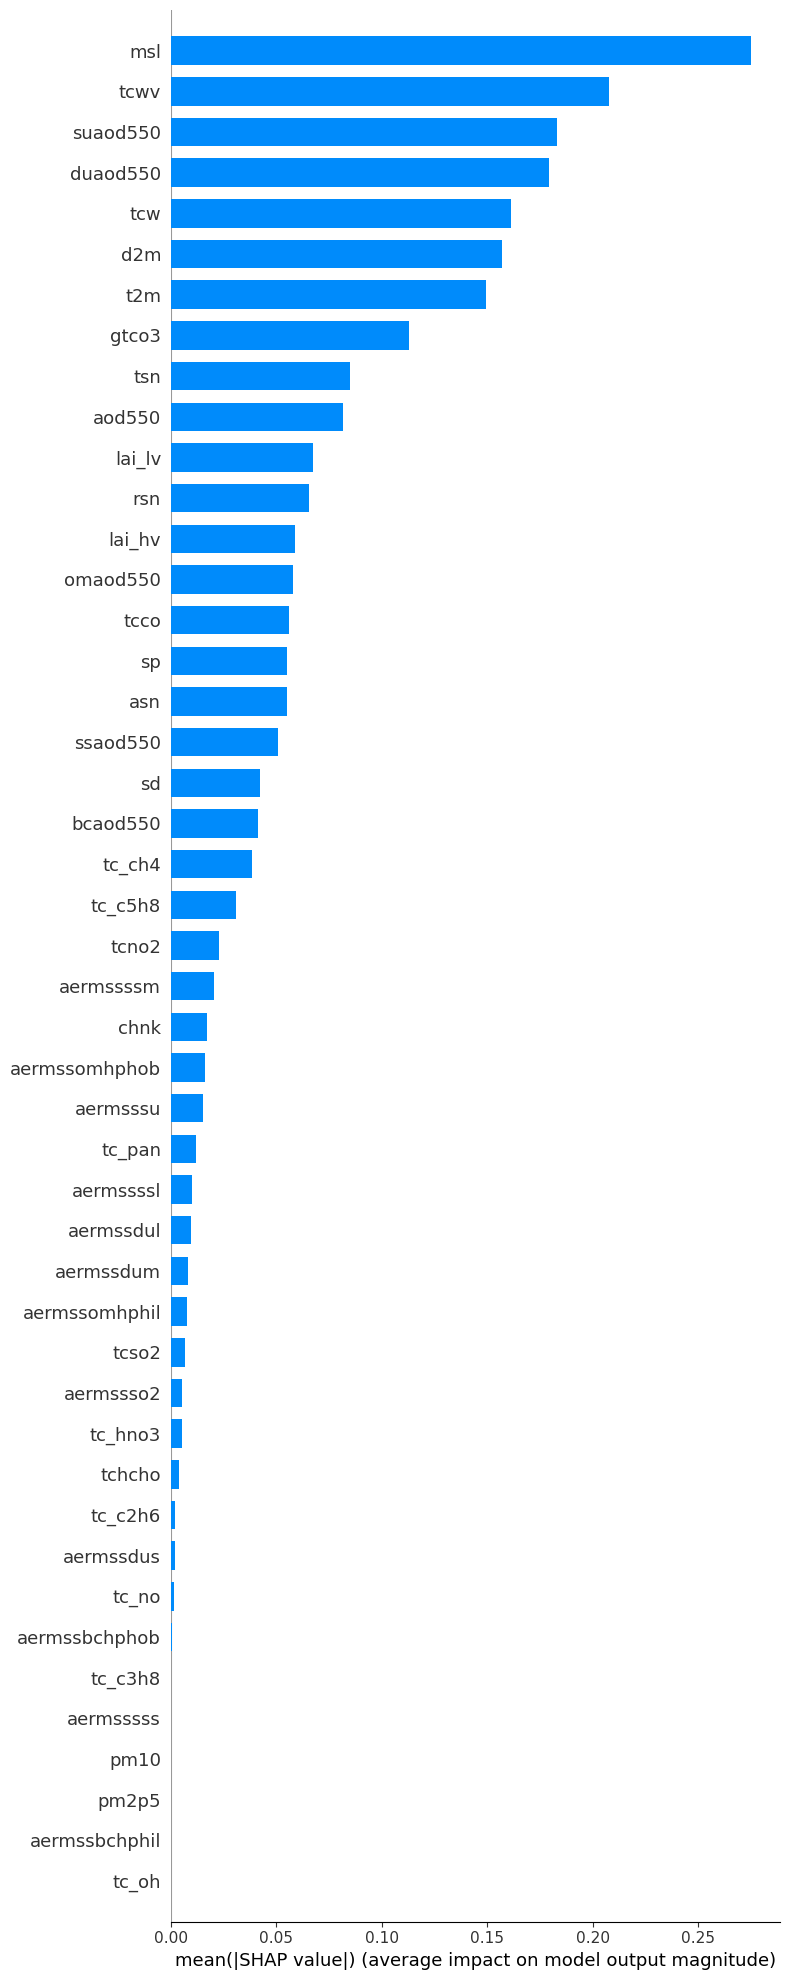

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

# Plot True Values on a map

In [32]:
##  load the county shapefile

SHAPE_PATH = os.path.join("County_shapefile",'gz_2010_us_050_00_500k.shp')
county_gdf = gpd.read_file(SHAPE_PATH)

county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [33]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum
## This step is necessary because there can be several counties with idential names. 

county_gdf['fips']=county_gdf['STATE'] + county_gdf['COUNTY']
county_gdf.dtypes
## convert the data type
county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041


In [34]:
full_df = pd.read_pickle("2010_data_interpolated.pkl")
full_df.head(2)

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,0.000001,0.000008,0.000002
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,0.000002,0.000008,0.000001


In [35]:
true_LE = full_df[['fips', 'MeanLifeExpectency']] ## get only fips and MeanLifeExpectancy column
type(true_LE)

pandas.core.frame.DataFrame

In [36]:
gpd_df = pd.merge(county_gdf, true_LE, on='fips', how='left') 
gpd_df= gpd_df.dropna()
gpd_df.head(2)
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374


In [37]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [38]:
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [39]:
## include only CONUS shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands', 'Puerto Rico' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


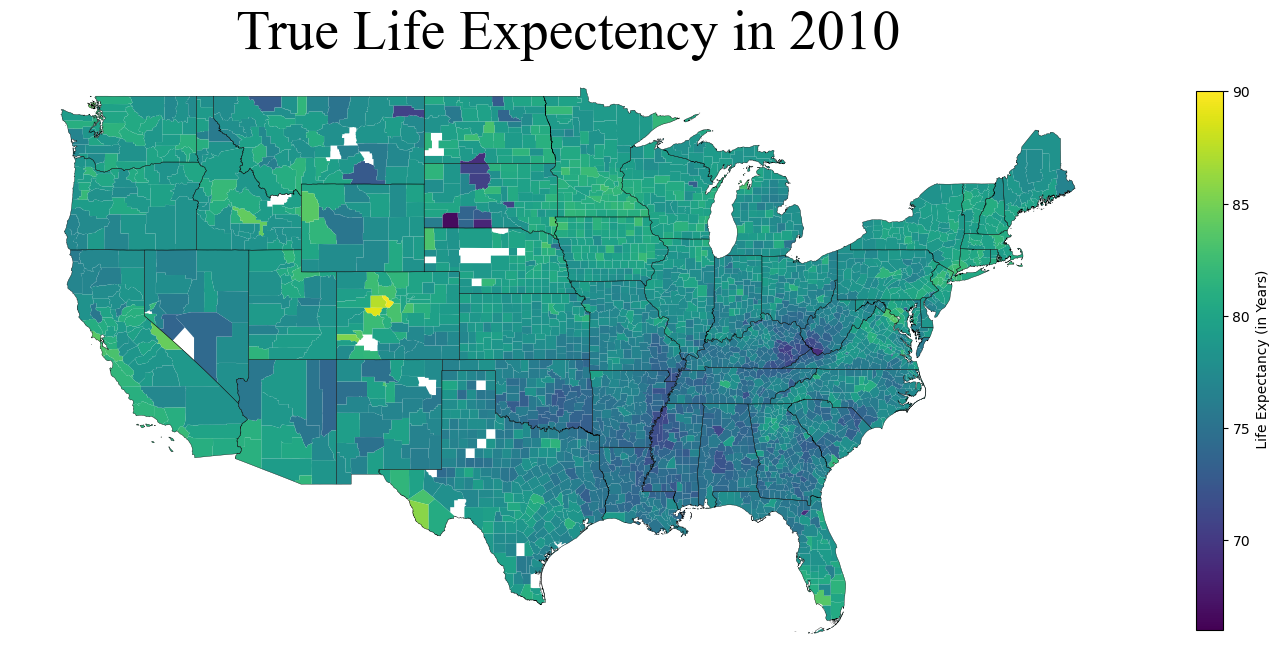

In [40]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('True Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Plot estimated life expectancy in train and test data

In [41]:
train_prediction

array([79.99626968, 80.7448994 , 80.09295557, ..., 79.11092983,
       74.69543988, 79.43157279])

In [42]:
y_train

569     79.135049
221     81.718966
382     79.442872
2910    81.882064
2932    75.749110
          ...    
2564    77.073261
290     76.047540
891     78.151702
2982    74.609215
2220    79.425603
Name: MeanLifeExpectency, Length: 2462, dtype: float64

In [43]:
y_train_df=pd.DataFrame([y_train]).T
y_train_df['Train Prediction']=train_prediction
y_train_df

,MeanLifeExpectency,Train Prediction
569,79.135049,79.996270
221,81.718966,80.744899
382,79.442872,80.092956
2910,81.882064,79.638060
2932,75.749110,75.895517
...,...,...
2564,77.073261,77.943065
290,76.047540,77.068130
891,78.151702,79.110930
2982,74.609215,74.695440


In [44]:
y_test_df=pd.DataFrame([y_test]).T
y_test_df
y_test_df['Test Prediction']=test_prediction
y_test_df

,MeanLifeExpectency,Test Prediction
941,76.584497,77.239480
673,77.437206,76.663689
1280,78.329584,77.819427
2663,76.418852,77.210620
2576,76.425418,76.221766
...,...,...
1478,71.206299,74.242589
1907,78.849369,77.694887
1265,78.028892,78.704018
2810,75.968299,76.176902


In [45]:
y_train_df=y_train_df.drop('MeanLifeExpectency', axis=1)
y_test_df=y_test_df.drop('MeanLifeExpectency', axis=1)

In [46]:
df_train = pd.merge(full_df, ## merge index with original data
                    y_train_df, left_index=True, right_index=True, how='left') 
df_train.head()

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Train Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,0.000002,75.266984
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,0.000001,76.774880
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,0.000004,4.877634e-09,0.000004,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,0.000003,26.033231,25.892798,0.000002,0.000004,0.000003,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,0.000001,75.468092
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,0.000004,4.880969e-09,0.000004,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,0.000003,25.483006,25.334140,0.000002,0.000004,0.000003,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,0.000002,74.456249
4,Blount County (Alabama),1009,2010,75.753407,Blount,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,0.000004,4.892594e-09,0.000003,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,0.000004,24.141938,23.988644,0.000002,0.000003,0.000003,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,0.000002,74.979778


In [47]:
df_train = df_train[['fips', 'Train Prediction']] ## get only fips and train prediction
df_train=df_train.dropna()

In [48]:
plot_train = pd.merge(county_gdf, df_train, on='fips', how='left') 
plot_train= plot_train.dropna()
plot_train.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Train Prediction
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.197278
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,75.814402
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.156952
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.736151
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.690065


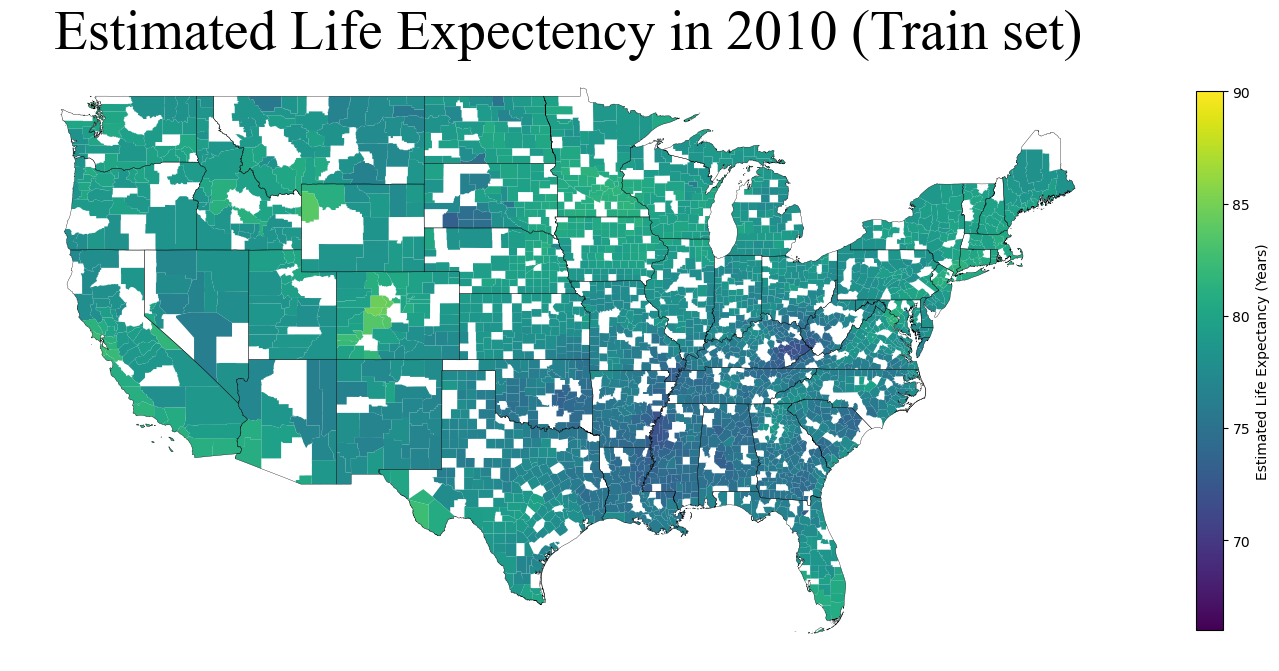

In [49]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_train.plot(ax=ax,column='Train Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Train set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

In [50]:
df_test = pd.merge(full_df, ## merge index with original data
                    y_test_df, left_index=True, right_index=True, how='left') 
df_test.head()

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Test Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,0.000002,NaN
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,0.000001,NaN
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,0.000004,4.877634e-09,0.000004,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,0.000003,26.033231,25.892798,0.000002,0.000004,0.000003,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,0.000001,NaN
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,0.000004,4.880969e-09,0.000004,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,0.000003,25.483006,25.334140,0.000002,0.000004,0.000003,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,0.000002,NaN
4,Blount County (Alabama),1009,2010,75.753407,Blount,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,0.000004,4.892594e-09,0.000003,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,0.000004,24.141938,23.988644,0.000002,0.000003,0.000003,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,0.000002,NaN


In [51]:
df_test = df_test[['fips', 'Test Prediction']] ## get only fips and test prediction
df_test=df_test.dropna()

In [52]:
plot_test = pd.merge(county_gdf, df_test, on='fips', how='left') 
plot_test= plot_test.dropna()
plot_test.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Test Prediction
7,0500000US01053,01,053,Escambia,County,945.080,"POLYGON ((-87.16308 30.99904, -87.16408 30.999...",1053,74.876193
9,0500000US01061,01,061,Geneva,County,574.408,"POLYGON ((-85.77267 30.99462, -85.77966 30.994...",1061,75.742053
10,0500000US01067,01,067,Henry,County,561.750,"POLYGON ((-85.04793 31.51426, -85.04845 31.513...",1067,75.138308
12,0500000US01077,01,077,Lauderdale,County,667.697,"POLYGON ((-87.29922 35.00092, -87.29918 35.000...",1077,75.121098
29,0500000US01059,01,059,Franklin,County,633.821,"POLYGON ((-88.16137 34.41963, -88.15867 34.442...",1059,75.108651


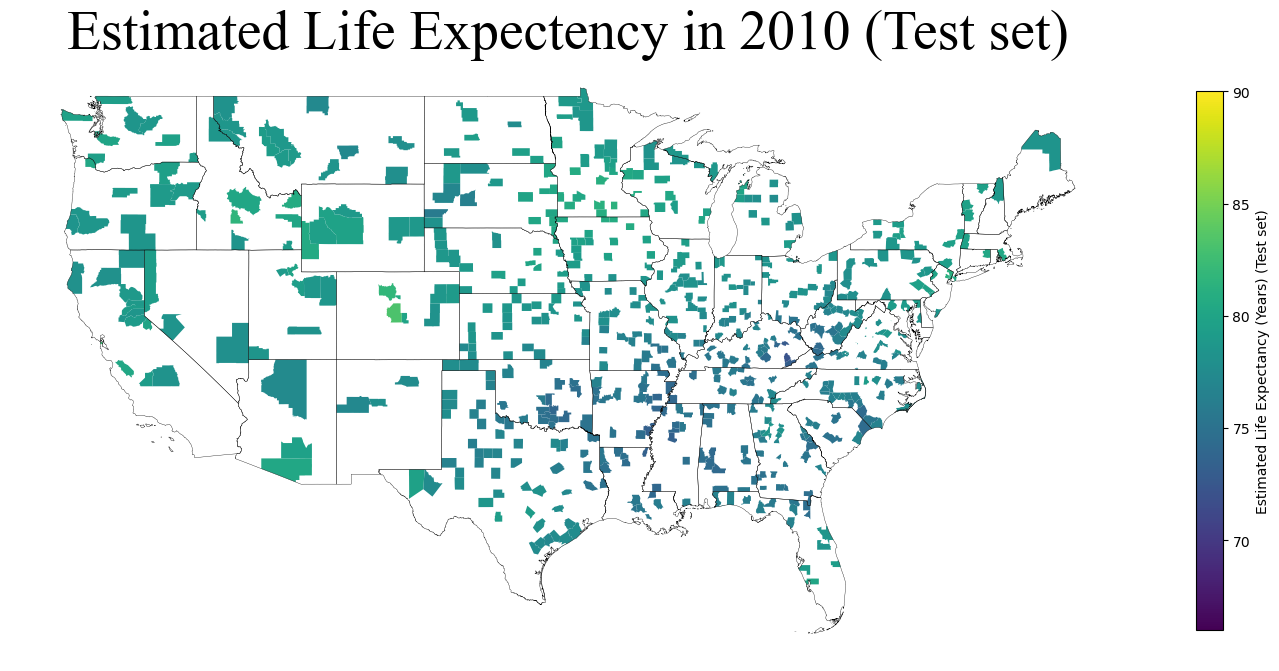

In [53]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_test.plot(ax=ax,column='Test Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years) (Test set)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Test set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Combine train and test set

In [54]:
plot_train=plot_train.rename(columns={"Train Prediction": "Estimated"})
plot_test=plot_test.rename(columns={"Test Prediction": "Estimated"})

final_df=pd.concat([plot_train, plot_test])
final_df = final_df[['fips', 'Estimated']]
final_df

,fips,Estimated
0,1029,74.197278
1,1031,75.814402
2,1037,75.156952
3,1039,74.736151
4,1041,74.690065
...,...,...
3126,56013,79.791171
3128,56017,78.920224
3132,56035,79.455835
3136,56023,80.552119


In [55]:
combined_plot = pd.merge(county_gdf, final_df, on='fips', how='left') 
combined_plot=combined_plot.dropna()

combined_plot

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Estimated
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.197278
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,75.814402
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.156952
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.736151
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.690065
...,...,...,...,...,...,...,...,...,...
3138,0500000US56027,56,027,Niobrara,County,2626.037,"POLYGON ((-104.05298 42.85955, -104.05286 42.7...",56027,78.787398
3139,0500000US56031,56,031,Platte,County,2084.208,"POLYGON ((-104.77417 42.60996, -104.76422 42.6...",56031,78.903032
3140,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037,78.504874
3141,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043,78.484125


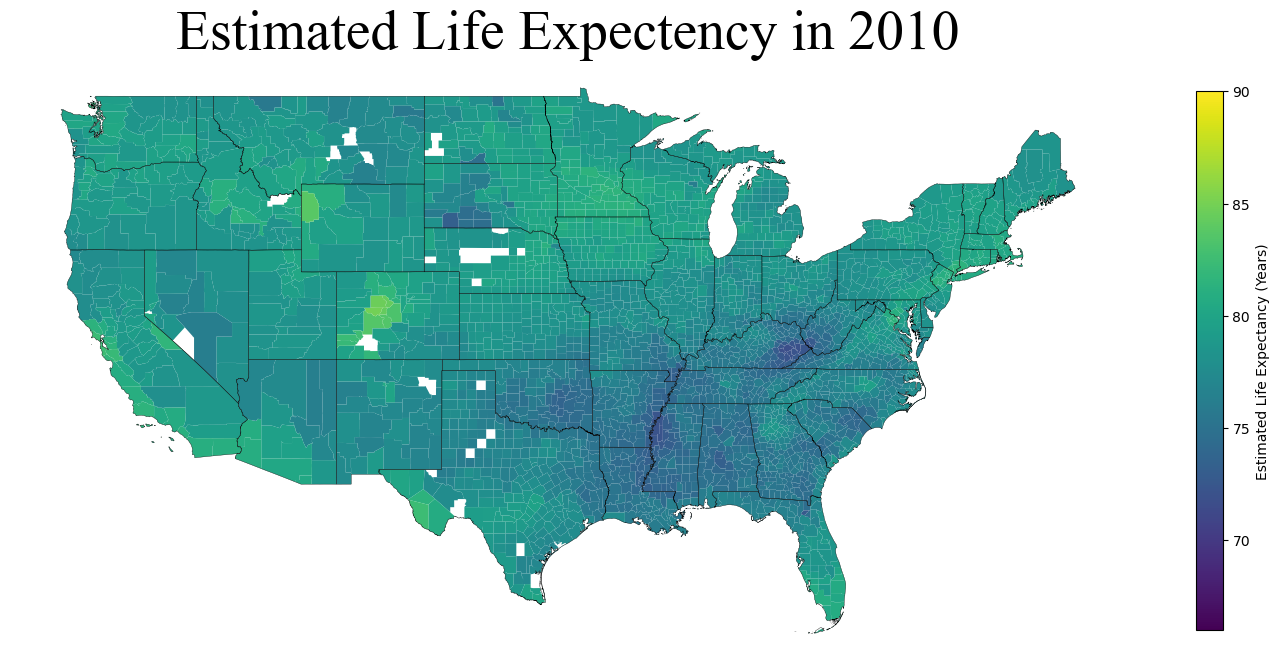

In [56]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
combined_plot.plot(ax=ax,column='Estimated', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()